# Your work: what you have to do
Modify the given Jupyter notebook on decision trees on Iris data and perform the following tasks:

1. get an artificial inflation of some class in the training set by a given factor: 10 (weigh more the classes virginica e versicolor which are more difficult to discriminate). Learn the tree in these conditions.

    1.b) modify the weight of some classes (set to 10 the weights for misclassification between virginica into versicolor and vice versa) and learn the tree in these conditions. You should obtain similar results as for step 1.
2. learn trees but try to avoid overfitting (by improving the error on the test set) tuning the hyper-parameters on: the minimum number of samples per leaf, max depth of the tree, min_impurity_decrease parameters, max leaf nodes, etc.
3. build the confusion matrix of the created tree models on the test set and show them. 
4. build the ROC curves (or coverage curves in coverage space) and plot them for each tree model you have created: for each model you have to build three curves, one for each class, considered in turn as the positive class.

In [3]:
import graphviz
import numpy as np
from sklearn import tree
from itertools import cycle
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.datasets import load_iris
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score # will be used to separate training and test
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier




iris = load_iris()
iris_map = {0: 'setosa', 1:'versicolor', 2:'virginica'}

In [38]:
# Helpers

def pretty_index(index):
    iris_map = {0: 'setosa', 1:'versicolor', 2:'virginica'}
    return iris_map[index]

def pretty_class(array):
    return list(map(pretty_index, array))

def prediction_accuracy(array1, array2):
    assert len(array1) == len(array2)

    length = len(array2)
    different = length

    for i in range(len(array1)):
        if array1[i] == array2[i]:
            different -= 1

    if different == 0:
        different = length

    return different / length

def print_roc_curve(clf):
    # Binarize the output
    y = label_binarize(iris.target, classes=[0, 1, 2])
    n_classes = y.shape[1]

    X_train, X_test, Y_train, Y_test = train_test_split(iris.data, y, test_size=0.2, random_state=451)
    classifier = OneVsRestClassifier(clf)
    y_score = classifier.fit(X_train, Y_train).predict_proba(X_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i, color in zip(range(n_classes), cycle(['blue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                label='ROC curve of class {0} (AUC = {1:0.2f})'
                ''.format(pretty_index(i), roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curves')
    plt.legend(loc="lower right")
    plt.show()  


In [39]:
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2)

In [40]:
x_train_oversampled = x_train
y_train_oversampled = y_train

for i in range(10):

    np.append(
        x_train_oversampled,
        x_train[y_train == 2][np.random.permutation(10)])
    np.append(
        x_train_oversampled,
        x_train[y_train == 1][np.random.permutation(10)])

    np.append(
        y_train_oversampled,
        [2,2,2,2,2,2,2,2,2,2]
    )
    np.append(
        y_train_oversampled,
        [1,1,1,1,1,1,1,1,1,1]
    )

# 1. Artificial Inflation

Oversampling delle classi versicolor e virginica

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         7
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[[10  0  0]
 [ 0  7  0]
 [ 0  0 13]]

[1.  1.  1.  0.8 1.  1.  0.8 1.  1.  1.  0.8 1.  1.  1.  0.8 1.  1.  0.8
 1.  0.8 1.  0.8 1.  1.  1.  1.  1.  1.  1.  1. ]


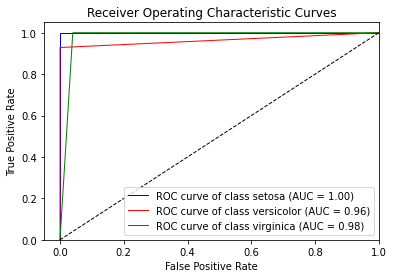

In [41]:
tree_clf = tree.DecisionTreeClassifier(criterion="entropy",random_state=300)
trained_clf = tree_clf.fit(x_train_oversampled, y_train_oversampled)

print(classification_report(y_test, trained_clf.predict(x_test), target_names=iris.target_names))
print(confusion_matrix(y_test, trained_clf.predict(x_test)))
print()
print(cross_val_score(tree_clf, iris.data, iris.target, cv=30))
print_roc_curve(trained_clf)

# 1b. Class Weighting

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         7
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[[10  0  0]
 [ 0  7  0]
 [ 0  0 13]]

[1.  1.  1.  0.8 1.  1.  0.8 1.  1.  1.  0.8 1.  1.  1.  0.8 1.  1.  0.8
 1.  0.8 1.  0.8 0.8 1.  0.8 1.  1.  1.  1.  1. ]


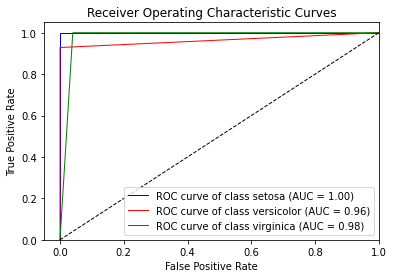

In [46]:
wtree_clf = tree.DecisionTreeClassifier(criterion="entropy",random_state=310, class_weight={0:.9,1:.1})
trained_wtree = wtree_clf.fit(x_train, y_train)
print(classification_report(y_test, trained_wtree.predict(x_test), target_names=iris.target_names))
print(confusion_matrix(y_test, trained_wtree.predict(x_test)))
print()
print(cross_val_score(wtree_clf, iris.data, iris.target, cv=30))
print_roc_curve(trained_wtree)


In [9]:
y_train

array([0, 1, 2, 0, 1, 2, 0, 2, 2, 2, 1, 1, 2, 0, 2, 2, 1, 1, 0, 0, 2, 0,
       0, 0, 2, 2, 1, 2, 0, 1, 0, 1, 2, 2, 2, 0, 2, 2, 1, 0, 0, 1, 2, 1,
       2, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1, 2, 1, 1, 1,
       0, 0, 0, 0, 1, 2, 0, 2, 0, 1, 1, 1, 2, 2, 0, 2, 1, 0, 2, 0, 0, 2,
       2, 1, 1, 1, 2, 0, 0, 0, 1, 1, 2, 1, 2, 0, 2, 1, 1, 1, 0, 1, 2, 1,
       0, 0, 2, 1, 2, 0, 1, 1, 2, 1])

# Control Group

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.92      0.92      0.92        13
   virginica       0.86      0.86      0.86         7

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

[[10  0  0]
 [ 0 12  1]
 [ 0  1  6]]

[1.  1.  1.  1.  1.  1.  0.8 1.  1.  1.  0.8 1.  0.8 1.  0.8 1.  1.  0.8
 1.  0.8 1.  0.8 1.  1.  0.8 1.  1.  1.  1.  1. ]


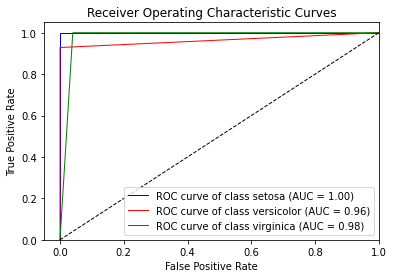

In [265]:
sampletree_clf = tree.DecisionTreeClassifier(class_weight=None)
trained_sampletree_clf = sampletree_clf.fit(x_train, y_train)
print(classification_report(y_test, trained_sampletree_clf.predict(x_test), target_names=iris.target_names))
print(confusion_matrix(y_test, trained_sampletree_clf.predict(x_test)))
print()
print(cross_val_score(sampletree_clf, iris.data, iris.target, cv=30))
print_roc_curve(trained_sampletree_clf)

# 2. Best Tree Training

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         7
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

[[10  0  0]
 [ 0  7  0]
 [ 0  0 13]]

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.8 1.  0.8 1.  0.8 1.  1.  1.
 1.  1.  1.  0.6 1.  1.  1.  1.  1.  1.  1.  1. ]


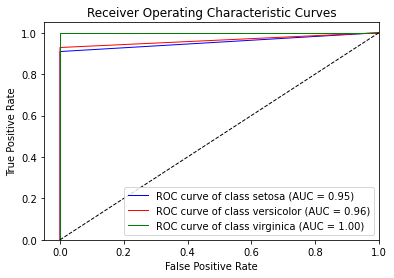

In [43]:
best_clf1 = tree.DecisionTreeClassifier(criterion="entropy", random_state=451, splitter="random", class_weight="balanced")
trained_best_clf1 = best_clf1.fit(x_train, y_train)
print(classification_report(y_test, trained_best_clf1.predict(x_test), target_names=iris.target_names))
print(confusion_matrix(y_test, trained_best_clf1.predict(x_test)))
print()
print(cross_val_score(best_clf1, iris.data, iris.target, cv=30))
print_roc_curve(trained_best_clf1)

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.88      1.00      0.93         7
   virginica       1.00      0.92      0.96        13

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.96        30
weighted avg       0.97      0.97      0.97        30

[[10  0  0]
 [ 0  7  0]
 [ 0  1 12]]

[1.  1.  1.  1.  1.  1.  0.8 1.  1.  1.  0.8 1.  1.  1.  0.8 1.  1.  0.8
 1.  1.  1.  0.8 1.  1.  1.  1.  1.  1.  1.  1. ]


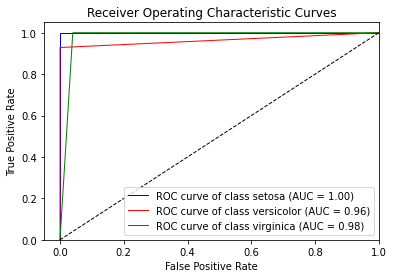

In [44]:
best_clf2 = tree.DecisionTreeClassifier(criterion="gini", random_state=451, splitter="best", min_samples_leaf=3, class_weight="balanced")
trained_best_clf2 = best_clf2.fit(x_train, y_train)
print(classification_report(y_test, trained_best_clf2.predict(x_test), target_names=iris.target_names))
print(confusion_matrix(y_test, trained_best_clf2.predict(x_test)))
print()
print(cross_val_score(best_clf2, iris.data, iris.target, cv=30))
print_roc_curve(trained_best_clf2)